In [ ]:
!pip install pandas scikit-learn flask flask-restful


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
job_descriptions = pd.read_csv('/content/job_descriptions.csv')
print(job_descriptions.head())

   job_id                  job_title        company  \
0       1       Full Stack Developer       TechCorp   
1       2             Data Scientist      DataWorks   
2       3         Frontend Developer         WebGen   
3       4          Backend Developer       CodeBase   
4       5  Machine Learning Engineer  AI Innovators   

                                                text  Unnamed: 4  Unnamed: 5  \
0  We are looking for a Full Stack Developer with...         NaN         NaN   
1  Seeking a Data Scientist skilled in Python, ma...         NaN         NaN   
2  Frontend Developer required with proficiency i...         NaN         NaN   
3  Hiring a Backend Developer experienced in Pyth...         NaN         NaN   
4  Machine Learning Engineer needed with expertis...         NaN         NaN   

   Unnamed: 6  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [ ]:
resumes = pd.read_csv('/content/resumes.csv')
print(resumes.head())

                             accomplishments_segment             degree  \
0                                                NaN  MS , B.TECH , PhD   
1                                                NaN  B.E , MS , M.TECH   
2  Successfully cleared and completed the course ...   MS , B.TECH , BS   
3                                                NaN      B.E , MS , BS   
4                                                NaN   MS , B.TECH , BS   

                                   education_segment  \
0                                                NaN   
1  M.Tech. Data Science\nJSS Science And Technolo...   
2  Degree\nInstitute\nBoard/University\nYear\nPer...   
3                                                NaN   
4                                                NaN   

                         emails  \
0    sutarvinayak2063@gmail.com   
1             pooj.vs@gmail.com   
2  khandelwal.ashwin5@gmail.com   
3                           NaN   
4                           NaN   

 

In [ ]:
job_descriptions['cleaned_text'] = job_descriptions['text'].apply(lambda x: x.lower())
job_descriptions['cleaned_text'] = job_descriptions['cleaned_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
job_descriptions['cleaned_text'] = job_descriptions['cleaned_text'].apply(lambda x: re.sub(r'\W', ' ', x))
job_descriptions['cleaned_text'] = job_descriptions['cleaned_text'].apply(lambda x: re.sub(r'\d', '', x))

In [ ]:
resumes['combined_text'] = resumes['text']
resumes['combined_text'] = resumes['combined_text'].apply(lambda x: x.lower())
resumes['combined_text'] = resumes['combined_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
resumes['combined_text'] = resumes['combined_text'].apply(lambda x: re.sub(r'\W', ' ', x))
resumes['combined_text'] = resumes['combined_text'].apply(lambda x: re.sub(r'\d', '', x))

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
job_description_vectors = vectorizer.fit_transform(job_descriptions['cleaned_text'])

In [ ]:
resume_vectors = vectorizer.transform(resumes['combined_text'])

In [ ]:
print(job_description_vectors.shape)
print(resume_vectors.shape)

(10, 67)
(1573, 67)


In [ ]:
similarity_scores = cosine_similarity(resume_vectors, job_description_vectors)

In [ ]:
ranked_resumes = []
for job_idx in range(similarity_scores.shape[1]):
    ranked_resumes.append(resumes.assign(relevance=similarity_scores[:, job_idx]).sort_values(by='relevance', ascending=False))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
top_10_resumes = ranked_resumes[0].head(10)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 59819 (\ue9ab) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 59824 (\ue9b0) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


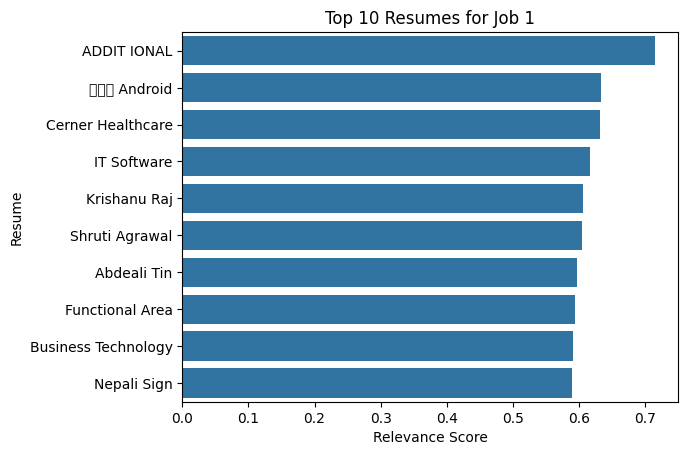

In [ ]:
sns.barplot(x='relevance', y='name', data=top_10_resumes)
plt.title('Top 10 Resumes for Job 1')
plt.xlabel('Relevance Score')
plt.ylabel('Resume')
plt.show()

In [ ]:
from flask import Flask, request, jsonify
from flask_restful import Api, Resource

app = Flask(__name__)
api = Api(app)

class RankResumes(Resource):
    def post(self):
        data = request.get_json()
        new_resumes = pd.DataFrame(data)
        new_resumes['combined_text'] = new_resumes['text'].apply(lambda x: x.lower())
        new_resumes['combined_text'] = new_resumes['combined_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
        new_resumes['combined_text'] = new_resumes['combined_text'].apply(lambda x: re.sub(r'\W', ' ', x))
        new_resumes['combined_text'] = new_resumes['combined_text'].apply(lambda x: re.sub(r'\d', '', x))

        new_resume_vectors = vectorizer.transform(new_resumes['combined_text'])
        job_id = request.args.get('job_id')
        job_idx = job_descriptions[job_descriptions['job_id'] == int(job_id)].index[0]

        similarity_scores = cosine_similarity(new_resume_vectors, job_description_vectors[job_idx])
        new_resumes['relevance'] = similarity_scores[:, 0]
        ranked_resumes = new_resumes.sort_values(by='relevance', ascending=False)

        return jsonify(ranked_resumes[['name', 'relevance']].to_dict(orient='records'))

api.add_resource(RankResumes, '/rank')

if __name__ == '__main__':

    app.run(host='localhost', port=5000, debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://localhost:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
from bs4 import BeautifulSoup
import requests

url = 'https://example.com/job-listings'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

job_titles = [title.text for title in soup.find_all(class_='job-title')]
job_texts = [desc.text for desc in soup.find_all(class_='job-description')]

additional_job_descriptions = pd.DataFrame({'job_title': job_titles, 'text': job_texts})
job_descriptions = pd.concat([job_descriptions, additional_job_descriptions], ignore_index=True)
